# Preserving Heritage: Enhancing Tourism with AI - Part I

### Problem statement
There are centuries old historical structures that preserve a country's and community's
history for future generations and promote tourism opportunities.
To improve tourism, a government agency decides to use advanced machine learning
techniques to monitor the condition of these historical structures and report if any of
them need maintenance.
Also, understanding customers (tourists) and their expectations is critical for eﬀective
marketing and promotion of tourism. A recommendation engine is an excellent way to
supplement existing marketing outreach.

### Objectives
- **Part 1:** XYZ Pvt. Ltd., a leading industry consulting firm, has been hired to help the cause by
developing an intelligent and automated AI model using TensorFlow that can predict the
category of a structure in an image.

- **Part 2:** The second objective of this project requires you to perform exploratory data analysis
and develop a recommendation engine that will help tourists visit their places of interest.


### Part 1: Create deep learning model that predict the category of a structure in an image

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import random

In [25]:
main_folder = "/content/drive/MyDrive/Colab Notebooks/CalTech projects/Capstone/Capstone 2/Part 1/dataset_hist_structures 2/dataset_hist_structures"

train_dir = f'{main_folder}/Stuctures_Dataset'
test_dir = f'{main_folder}/Dataset_test/Dataset_test_original_1478'

In [ ]:
dataset_path = train_dir

samples_per_class = 10

class_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

for class_name in class_dirs:
    class_path = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    sample_images = random.sample(image_files, min(samples_per_class, len(image_files)))

    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Class: {class_name}", fontsize=16)

    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, samples_per_class, i+1)
        plt.imshow(img)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [26]:
import os
from collections import defaultdict

def count_images_per_class(directory):
    class_counts = defaultdict(int)
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            count = len([
                f for f in os.listdir(class_path)
                if os.path.isfile(os.path.join(class_path, f))
            ])
            class_counts[class_folder] = count
    return class_counts

train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

print("\nTrain Set Sample Counts:")
for cls, count in train_counts.items():
    print(f"Category '{cls}': {count} images")

print("\nTest Set Sample Counts:")
for cls, count in test_counts.items():
    print(f"Category '{cls}': {count} images")



Train Set Sample Counts:
Category 'gargoyle': 1571 images
Category 'apse': 514 images
Category 'flying_buttress': 407 images
Category 'vault': 1110 images
Category 'dome(inner)': 616 images
Category 'column': 1919 images
Category 'stained_glass': 1033 images
Category 'dome(outer)': 1177 images
Category 'bell_tower': 1059 images
Category 'altar': 829 images

Test Set Sample Counts:
Category 'flying_buttress': 78 images
Category 'apse': 57 images
Category 'bell_tower': 171 images
Category 'dome(outer)': 168 images
Category 'stained_glass': 163 images
Category 'vault': 164 images
Category 'column': 210 images
Category 'gargoyle': 240 images
Category 'dome(inner)': 86 images
Category 'altar': 140 images


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import os

img_size = (224, 224)
batch_size = 10 #smaller batch sizes prevent memory bottlenecks

train_ds = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    )

val_ds = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    )

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Using EfficientNetB0 as it performs well for image classification and is well-optimized.
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)      # Dense layer 1
x = Dropout(0.5)(x)                        # Dropout to prevent overfitting
x = Dense(256, activation='relu')(x)      # Dense layer 2
x = Dropout(0.3)(x)                        # Another dropout

output_classes = train_ds.element_spec[1].shape[-1]
outputs = Dense(output_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Found 10235 files belonging to 10 classes.
Using 8188 files for training.
Found 10235 files belonging to 10 classes.
Using 2047 files for validation.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,839,341 (18.46 MB)

 Trainable params: 4,797,318 (18.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

steps_per_epoch = 1024
validation_steps = 148

early_stop_callback = EarlyStopping(
    monitor='val_accuracy',      # Metric to watch
    patience=3,                  # Number of epochs with no improvement before stopping
    mode='max',                  # Because we want accuracy to be high
    restore_best_weights=True,  # Restore model weights from the epoch with the best val_accuracy
    verbose=1                    # Print when training stops
)

checkpoint = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy',
    save_best_only=True, mode='max', verbose=1
)

callbacks=[early_stop_callback, checkpoint]

In [ ]:
# train without augmentation
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
    )

Epoch 1/10
 818/1024 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.2026 - loss: 2.1903

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.73649, saving model to best_model.h5


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 235s 107ms/step - accuracy: 0.2247 - loss: 2.1548 - val_accuracy: 0.7365 - val_loss: 1.4633
Epoch 2/10
 818/1024 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.6193 - loss: 1.4368 
Epoch 2: val_accuracy improved from 0.73649 to 0.85608, saving model to best_model.h5


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 72s 62ms/step - accuracy: 0.6313 - loss: 1.3969 - val_accuracy: 0.8561 - val_loss: 0.6510
Epoch 3/10
 819/1024 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.7883 - loss: 0.7926
Epoch 3: val_accuracy improved from 0.85608 to 0.89459, saving model to best_model.h5


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 78s 58ms/step - accuracy: 0.7912 - loss: 0.7798 - val_accuracy: 0.8946 - val_loss: 0.3692
Epoch 4/10
 819/1024 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.8430 - loss: 0.5441
Epoch 4: val_accuracy improved from 0.89459 to 0.92770, saving model to best_model.h5


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step - accuracy: 0.8442 - loss: 0.5381 - val_accuracy: 0.9277 - val_loss: 0.2569
Epoch 5/10
 818/1024 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.8815 - loss: 0.4138 
Epoch 5: val_accuracy improved from 0.92770 to 0.94865, saving model to best_model.h5


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 59s 58ms/step - accuracy: 0.8824 - loss: 0.4100 - val_accuracy: 0.9486 - val_loss: 0.1884
Epoch 6/10
 819/1024 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9049 - loss: 0.3188
Epoch 6: val_accuracy improved from 0.94865 to 0.95743, saving model to best_model.h5


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - accuracy: 0.9058 - loss: 0.3163 - val_accuracy: 0.9574 - val_loss: 0.1540
Epoch 7/10
 819/1024 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9303 - loss: 0.2428
Epoch 7: val_accuracy did not improve from 0.95743
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 67s 43ms/step - accuracy: 0.9296 - loss: 0.2434 - val_accuracy: 0.9568 - val_loss: 0.1383
Epoch 8/10
 819/1024 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.9366 - loss: 0.2063
Epoch 8: val_accuracy improved from 0.95743 to 0.95878, saving model to best_model.h5


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 97s 95ms/step - accuracy: 0.9377 - loss: 0.2043 - val_accuracy: 0.9588 - val_loss: 0.1408
Epoch 9/10
 818/1024 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9544 - loss: 0.1589 
Epoch 9: val_accuracy improved from 0.95878 to 0.96081, saving model to best_model.h5


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 141s 94ms/step - accuracy: 0.9541 - loss: 0.1597 - val_accuracy: 0.9608 - val_loss: 0.1259
Epoch 10/10
 818/1024 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9617 - loss: 0.1338
Epoch 10: val_accuracy improved from 0.96081 to 0.96216, saving model to best_model.h5


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 143s 95ms/step - accuracy: 0.9617 - loss: 0.1338 - val_accuracy: 0.9622 - val_loss: 0.1205
Restoring model weights from the end of the best epoch: 10.


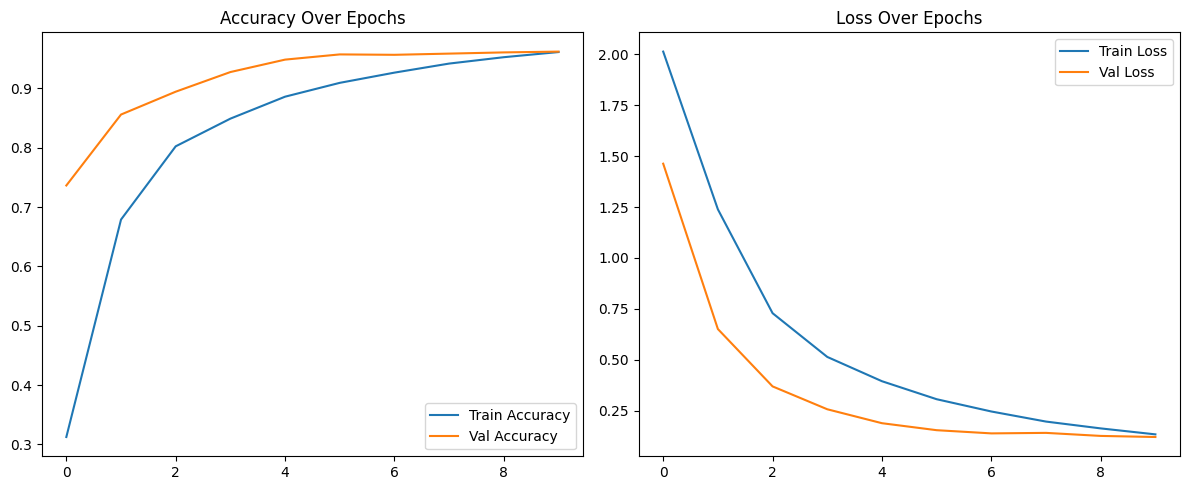

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


def augment_images(image, label):
    return data_augmentation(image), label

augmented_train_ds = train_ds.map(augment_images).prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
#train with augmentation
history_aug = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stop_callback],
    verbose=1
)

Epoch 1/10
 819/1024 ━━━━━━━━━━━━━━━━━━━━ 37s 183ms/step - accuracy: 0.1965 - loss: 2.2008

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1024/1024 ━━━━━━━━━━━━━━━━━━━━ 2570s 502ms/step - accuracy: 0.2144 - loss: 2.1696 - val_accuracy: 0.6446 - val_loss: 1.6690
Epoch 2/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 128s 116ms/step - accuracy: 0.5621 - loss: 1.5022 - val_accuracy: 0.8432 - val_loss: 0.8233
Epoch 3/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 115s 112ms/step - accuracy: 0.7376 - loss: 0.9241 - val_accuracy: 0.8824 - val_loss: 0.4519
Epoch 4/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 142s 112ms/step - accuracy: 0.8056 - loss: 0.6628 - val_accuracy: 0.9081 - val_loss: 0.3214
Epoch 5/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 115s 113ms/step - accuracy: 0.8410 - loss: 0.5169 - val_accuracy: 0.9331 - val_loss: 0.2460
Epoch 6/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 142s 139ms/step - accuracy: 0.8681 - loss: 0.4350 - val_accuracy: 0.9466 - val_loss: 0.1947
Epoch 7/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 175s 113ms/step - accuracy: 0.8835 - loss: 0.3712 - val_accuracy: 0.9514 - val_loss: 0.1679
Epoch 8/10
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 202s 171ms/step - accuracy: 0.

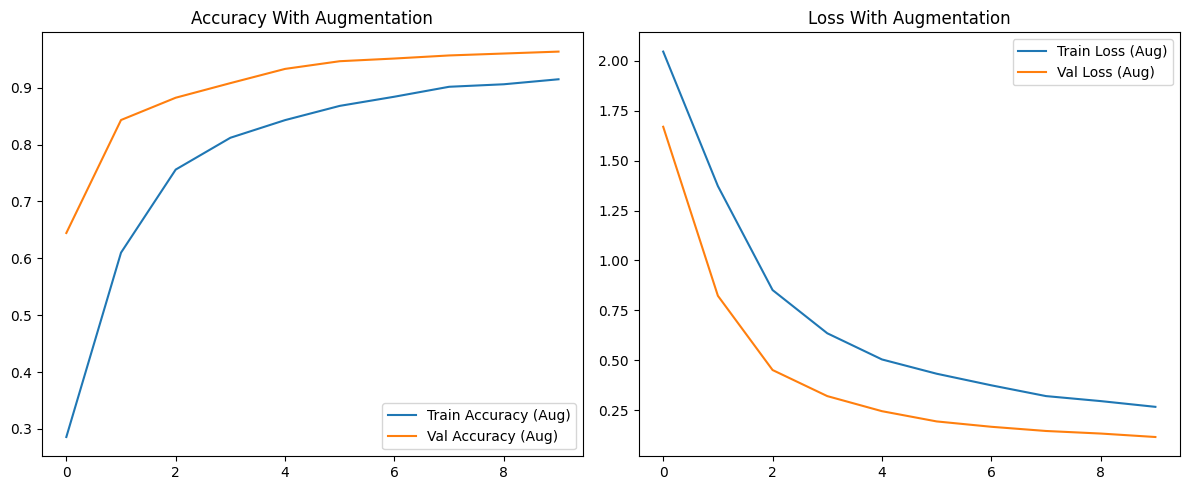

In [7]:
import matplotlib.pyplot as plt

acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy (Aug)')
plt.plot(epochs_range, val_acc, label='Val Accuracy (Aug)')
plt.title('Accuracy With Augmentation')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss (Aug)')
plt.plot(epochs_range, val_loss, label='Val Loss (Aug)')
plt.title('Loss With Augmentation')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
class_names = sorted(entry.name for entry in os.scandir(train_dir) if entry.is_dir())
class_names

['altar',
 'apse',
 'bell_tower',
 'column',
 'dome(inner)',
 'dome(outer)',
 'flying_buttress',
 'gargoyle',
 'stained_glass',
 'vault']

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


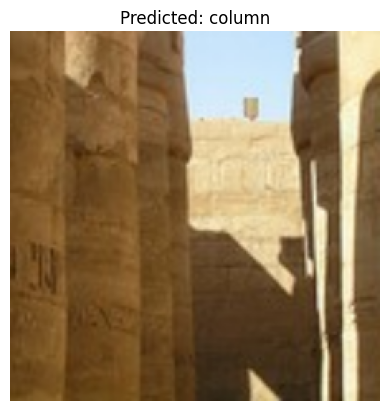

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


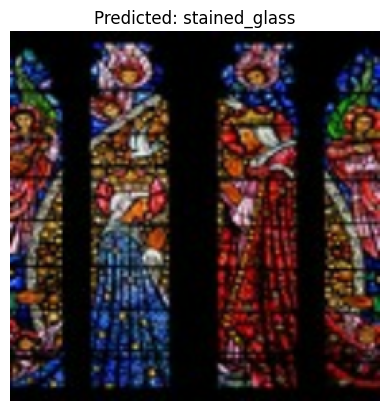

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


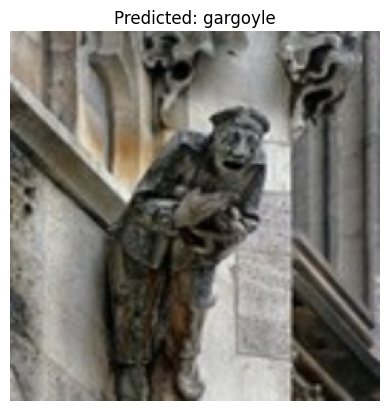

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


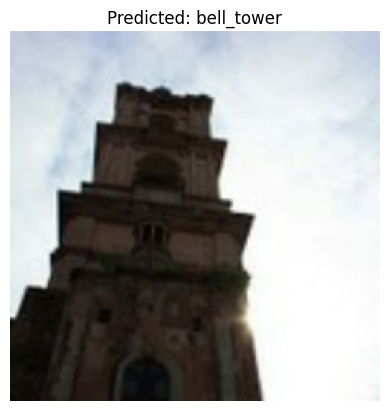

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


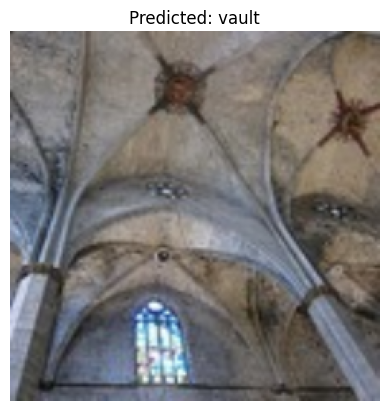

In [19]:
for images, labels in train_ds.take(1):
    for i in range(5):
        img = images[i].numpy()
        label = labels[i].numpy()

        # Model expects a batch of images
        img_batch = np.expand_dims(img, axis=0)
        prediction = model.predict(img_batch)
        predicted_class = class_names[np.argmax(prediction)]

        # Show the image and prediction
        plt.imshow(img.astype("uint8"))
        plt.axis("off")
        plt.title(f"Predicted: {predicted_class}")
        plt.show()